# SHAP

### Clasificación de eventos usando SHAP como seleccionador de características con los set de datos reducidos a 818238 eventos.

-------------------------------------------------------------------------------------------------------------------------------

Alex Toro y Raquel Pezoa

## Librerias necesarias.
-------------------------------------------------------------------------------------------------------------------------------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
import shap
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [3]:
import xgboost as xgb

In [4]:
import winsound

In [5]:
shap.initjs()

## Lectura del set de datos reducido.

- El set original proviene de https://www.kaggle.com/competitions/higgs-boson/data.
- Separación de la variable Label de las demas variables.
-------------------------------------------------------------------------------------------------------------------------------

In [6]:
df = pd.read_csv("/Users/Alex/Downloads/Pre-procesado_completo-EventID.csv")
Reducido_X_train = pd.read_csv("/Users/Alex/Downloads/Valores-X_TrainR.csv") 
# Valores training para la selección de características del conjunto reducido.

In [7]:
X = df.drop(labels=['Label'], axis=1)
Y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [8]:
len(X_test['EventId'])


163648

X_testTemp es la copia de X_test para la posterior modificación de X_testTemp.

-------------------------------------------------------------------------------------------------------------------------------

In [9]:
X_testTemp = X_test.copy() #datos de testing para la selección de características del conjunto grande.

Ingresando los valores de la columna de EventId (X_test del conjunto grande) a una lista.

-------------------------------------------------------------------------------------------------------------------------------

In [10]:
EventId_Grande = X_test["EventId"].values

La creacion de una lista que tendra los valores del EventId de X_train que proviene del conjunto reducido

In [11]:
l_EventId = []
for i in Reducido_X_train['EventId']:
    if(i in EventId_Grande):
        l_EventId.append(i)

In [12]:
frequency = 2500
duration = 1000
winsound.Beep(frequency, duration) # Avisa cuando termino la celda anterior.

## Eliminaciones de valores duplicados
Se eliminan los valores duplicados del conjunto reducido.

-------------------------------------------------------------------------------------------------------------------------------

In [13]:
l_EventId_Copia = l_EventId 

for k in l_EventId_Copia:
    suma = 0
    tamaño = 0
    for j in l_EventId_Copia:
        if(k == j):
            suma = suma+1
            if(suma > 1):
                l_EventId.pop(tamaño)
        tamaño = tamaño + 1
winsound.Beep(frequency, duration)

## Busqueda y eliminaciones
Se busca los valores del EventId de X_train del conjunto reducido que sean iguales a los valores del EventId provenientes de X_testTemp, luego se guardan en el mismo X_testTemp y se repite el ciclo hasta el último valor de la lista del conjunto reducido (X_train). Esto es para que los valores de testing del conjunto grande no contengan valores de training del conjunto reducido.

-------------------------------------------------------------------------------------------------------------------------------

In [14]:
for i in l_EventId:
    X_testTemp=X_testTemp.drop(X_testTemp[X_testTemp['EventId']==i].index)

In [15]:
winsound.Beep(frequency, duration)

## Eliminación del EventId.
Se elimina la columna EventId para el entrenamiento con el modelo de XGBoost.

In [16]:
X_train = X_train.drop(labels=['EventId'], axis=1)
X_test = X_test.drop(labels=['EventId'], axis=1)
X_testTemp = X_testTemp.drop(labels=['EventId'], axis=1)

## Carga del modelo de XGBoost
Se carga el modelo proveniente del SHAP que usa el dataset reducido y el cual también se sacaron los valores de entrenamiento para los procesos anteriormente descritos.
Este modelo se usa para la selección de características.

-------------------------------------------------------------------------------------------------------------------------------

In [17]:
model = xgb.Booster()
model.load_model("SHAP-XGBoostClassifier-EventId.model")

### SHAP seleccionado características.

In [18]:
# Fits the explainer
explainer = shap.TreeExplainer(model = model)
# Calculates the SHAP values - It takes some time

In [19]:
# Evaluate SHAP values
shap_values = explainer.shap_values(X_testTemp)

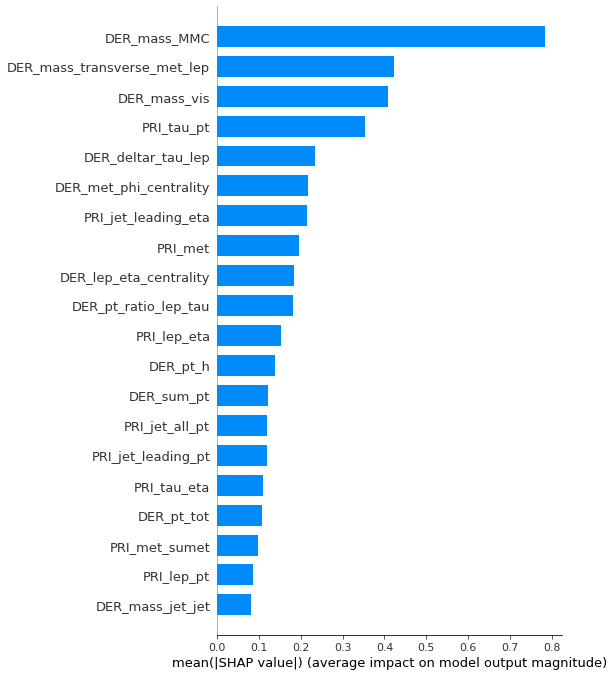

In [21]:
shap.summary_plot(shap_values, X_testTemp, plot_type="bar")

### Obteniendo la media de los valores absolutos de SHAP (|SHAP value|).
-------------------------------------------------------------------------------------------------------------------------------

In [22]:
meanL = []
for valus in range(0,len(shap_values)):
    for singularidad in range(0,len(shap_values[valus])):
        if valus==0:
            meanL.append(abs(shap_values[valus][singularidad]))
        else:
            meanL[singularidad]=meanL[singularidad]+abs(shap_values[valus][singularidad])

In [23]:
winsound.Beep(frequency, duration)

### Convertir los datos a  una lista de duplas.

- Se convierte la media de los valores absolutos de SHAP junto a las columnas del dataframe en una lista de duplas.
- Se realizan las duplas para así poder reordenar las variables de la más relevante a la menos relevante.
- Se Reordena la duplas de mayor a menor.
- Se separan las duplas en listas separadas y transformar las 20 primeras en arreglos de numpy.
-------------------------------------------------------------------------------------------------------------------------------

In [24]:
meanL=list(map(lambda x: x / len(shap_values), meanL))
l=[]
for feature in zip(meanL,X_train.columns):
    l.append(feature)

In [25]:
l.sort(reverse=True)

Se le incorpora el EventId a la lista de las mejores variables.

In [26]:
l_v = ['EventId']
for importance in range(len(l)):
    for var in range(len(l[importance])):
        if(var == 1):
            l_v.append(l[importance][var])
            

In [27]:
winsound.Beep(frequency, duration)

In [28]:
x = np.array(l_v[0:21])

Se guardan en X_BestFeature las mejores 20 variables y el EventId.

In [29]:
X_BestFeature = X[x]

### Entrenamiento, testeo y optimizacion de parametros de DMatrix de XGBoost con las variables entregadas por SHAP.
-------------------------------------------------------------------------------------------------------------------------------

In [30]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_BestFeature, Y, test_size=0.2, random_state=0)

In [31]:
Reducido_X_train2 = pd.read_csv("/Users/Alex/Downloads/Valores-X_Train2R.csv") 
# Valores training para la clasificación del conjunto reducido.

X_testTemp2 es la copia de X_test2 para la posterior modificación de X_testTemp2.

-------------------------------------------------------------------------------------------------------------------------------

In [32]:
X_testTemp2 = X_test2.copy() #datos de testing para la clasificación del conjunto grande.

Ingresando los valores de la columna de EventId (X_test2 del conjunto grande) a una lista.

-------------------------------------------------------------------------------------------------------------------------------

In [33]:
EventId_Grande2 = X_test2["EventId"].values

La creacion de una lista que tendra los valores del EventId de X_train2 que proviene del conjunto reducido

In [34]:
l_EventId2 = []
for i in Reducido_X_train2['EventId']:
    if(i in EventId_Grande2):
        l_EventId2.append(i)

In [35]:
winsound.Beep(frequency, duration)

## Eliminaciones de valores duplicados
Se eliminan los valores duplicados del conjunto reducido.

-------------------------------------------------------------------------------------------------------------------------------

In [36]:
l_EventId2_Copia = l_EventId2 

for k in l_EventId2_Copia:
    suma = 0
    tamaño = 0
    for j in l_EventId2_Copia:
        if(k == j):
            suma = suma+1
            if(suma > 1):
                l_EventId2.pop(tamaño)
        tamaño = tamaño + 1
winsound.Beep(frequency, duration)

y_testTemp2 es la copia de y_test2 para la posterior modificación de y_testTemp2.

-------------------------------------------------------------------------------------------------------------------------------

In [37]:
y_testTemp2 = y_test2.copy() #datos de testing para la clasificación del conjunto grande.

## Busqueda y eliminaciones
Se busca los valores del EventId de X_train del conjunto reducido que sean iguales a los valores del EventId provenientes de X_testTemp, luego se guardan en el mismo X_testTemp y se repite el ciclo hasta el último valor de la lista del conjunto reducido (X_train). Esto es para que los valores de testing del conjunto grande no contengan valores de training del conjunto reducido. Ademas se eliminan los valores de y_testTem2 que tienen el mismo indice de X_testTemp2.

-------------------------------------------------------------------------------------------------------------------------------

In [38]:
for i in l_EventId2:
    indexX_test2 = X_testTemp2[X_testTemp2['EventId']==i].index
    if(i == X_testTemp2['EventId'][indexX_test2.tolist()[0]]):
        y_testTemp2=y_testTemp2.drop(indexX_test2.tolist()[0])
    X_testTemp2=X_testTemp2.drop(indexX_test2)
    

In [39]:
winsound.Beep(frequency, duration)

## Eliminación del EventId.
Se elimina la columna EventId para el entrenamiento con el modelo de XGBoost.

In [40]:
X_train2 = X_train2.drop(labels=['EventId'], axis=1)
X_test2 = X_test2.drop(labels=['EventId'], axis=1)
X_testTemp2 = X_testTemp2.drop(labels=['EventId'], axis=1)

In [41]:
dtrain = xgb.DMatrix(X_train2, label=y_train2)
dtest = xgb.DMatrix(X_testTemp2, label=y_testTemp2) 
# Utilización de testing del conjunto grande sin datos de training del conjunto reducido.

In [42]:
from sklearn.metrics import mean_absolute_error


### Carga del modelo y predicciones.
-------------------------------------------------------------------------------------------------------------------------------

## Carga del modelo de XGBoost
Se carga el modelo proveniente del SHAP que usa el dataset reducido y el cual también se sacaron los valores de entrenamiento para los procesos anteriormente descritos.
Este modelo se usa para la clasificación.

-------------------------------------------------------------------------------------------------------------------------------

In [43]:
loaded_model = xgb.Booster()
loaded_model.load_model("SHAP-20%-EventId.model")
# And use it for predictions.

[22:33:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [44]:
Prediccion = loaded_model.predict(dtest) # Predicción con la clasificación de los datos de testing del conjunto grande

In [45]:
Prediccion.min()

-0.24815986

In [46]:
Prediccion.max()

1.3042631

In [47]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, classification_report, roc_curve, auc, roc_auc_score, ConfusionMatrixDisplay

In [48]:
testing_list =[]
for i in  np.linspace(0.1,0.9,9):
    d = {}
    y_p = Prediccion >= i
    print("Threshold:",i)
    cm = confusion_matrix(y_testTemp2,y_p)
    d["th"] = i
    d["F1"] = np.round(f1_score(y_testTemp2,y_p),2)
    d["Prec"] = np.round(precision_score(y_testTemp2,y_p),2)
    d["Rec"] = np.round(recall_score(y_testTemp2,y_p),2)
    d["Acc"] = np.round(accuracy_score(y_testTemp2,y_p),2)
    d["RocAuc"] = np.round(roc_auc_score(y_testTemp2,y_p),2)
    testing_list.append(d)

Threshold: 0.1
Threshold: 0.2
Threshold: 0.30000000000000004
Threshold: 0.4
Threshold: 0.5
Threshold: 0.6
Threshold: 0.7000000000000001
Threshold: 0.8
Threshold: 0.9


# Metricas para cada umbral.
- th: umbral
-------------------------------------------------------------------------------------------------------------------------------

In [49]:
testing_metrics_pd = pd.DataFrame(testing_list)
testing_metrics_pd

,th,F1,Prec,Rec,Acc,RocAuc
0,0.1,0.67,0.51,0.96,0.68,0.75
1,0.2,0.72,0.60,0.91,0.76,0.80
2,0.3,0.75,0.67,0.85,0.81,0.82
3,0.4,0.76,0.73,0.79,0.83,0.82
4,0.5,0.75,0.78,0.72,0.84,0.81
5,0.6,0.72,0.83,0.64,0.83,0.78
6,0.7,0.67,0.87,0.54,0.82,0.75
7,0.8,0.58,0.90,0.43,0.79,0.70
8,0.9,0.42,0.94,0.27,0.75,0.63


In [50]:
print(testing_metrics_pd.to_latex(index=False))

\begin{tabular}{rrrrrr}
\toprule
 th &   F1 &  Prec &  Rec &  Acc &  RocAuc \\
\midrule
0.1 & 0.67 &  0.51 & 0.96 & 0.68 &    0.75 \\
0.2 & 0.72 &  0.60 & 0.91 & 0.76 &    0.80 \\
0.3 & 0.75 &  0.67 & 0.85 & 0.81 &    0.82 \\
0.4 & 0.76 &  0.73 & 0.79 & 0.83 &    0.82 \\
0.5 & 0.75 &  0.78 & 0.72 & 0.84 &    0.81 \\
0.6 & 0.72 &  0.83 & 0.64 & 0.83 &    0.78 \\
0.7 & 0.67 &  0.87 & 0.54 & 0.82 &    0.75 \\
0.8 & 0.58 &  0.90 & 0.43 & 0.79 &    0.70 \\
0.9 & 0.42 &  0.94 & 0.27 & 0.75 &    0.63 \\
\bottomrule
\end{tabular}



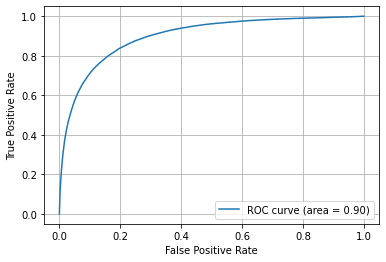

In [51]:
fpr, tpr, ths = roc_curve(y_testTemp2,  Prediccion)
auc_ = auc(fpr, tpr)
plt.plot(fpr,tpr, label='ROC curve (area = %.2f)' %auc_)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.grid()
plt.show()

In [52]:
for i in  np.linspace(0.1,0.9,9):
    print(i)
    y_p = Prediccion >= i
    print(classification_report(y_testTemp2, y_p))
    f1 = f1_score(y_testTemp2, y_p)
    prec = precision_score(y_testTemp2, y_p)
    rec = recall_score(y_testTemp2, y_p)
    acc = accuracy_score(y_testTemp2, y_p)
    cm=confusion_matrix(y_testTemp2, y_p)
    print("Matriz de confusión: ")
    print(cm)
    print("----------------------------------------------------------")
    print("F1: %.2f" %f1 , " -- prec: %.2f" %prec, " -- recall: %.2f" %rec, " -- acc: %.2f" %acc)
    print("----------------------------------------------------------")

0.1
              precision    recall  f1-score   support

           0       0.96      0.53      0.69     98140
           1       0.51      0.96      0.67     50389

    accuracy                           0.68    148529
   macro avg       0.74      0.75      0.68    148529
weighted avg       0.81      0.68      0.68    148529

Matriz de confusión: 
[[52484 45656]
 [ 2248 48141]]
----------------------------------------------------------
F1: 0.67  -- prec: 0.51  -- recall: 0.96  -- acc: 0.68
----------------------------------------------------------
0.2
              precision    recall  f1-score   support

           0       0.94      0.69      0.80     98140
           1       0.60      0.91      0.72     50389

    accuracy                           0.76    148529
   macro avg       0.77      0.80      0.76    148529
weighted avg       0.82      0.76      0.77    148529

Matriz de confusión: 
[[67951 30189]
 [ 4716 45673]]
----------------------------------------------------------


In [53]:
umbral = 0.4

In [54]:
maskSignal=Prediccion>umbral

In [55]:
predicBin=[]
for i in maskSignal:
    if(i==True):
        predicBin.append(1)
    else:
        predicBin.append(0)

In [56]:
npPredict=np.array(predicBin)

In [57]:
cm=confusion_matrix(y_testTemp2, npPredict)
cm

array([[83425, 14715],
       [10748, 39641]], dtype=int64)

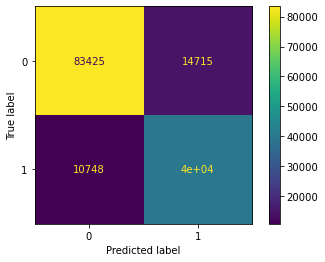

In [58]:
cm_display = ConfusionMatrixDisplay(cm).plot()

In [59]:
f1= f1_score(y_testTemp2, npPredict)
f1

0.7569048641939949

prec=precision_score(y_test2, npPredict)
prec

In [60]:
rec=recall_score(y_testTemp2, npPredict)
rec

0.7866994780606879

In [61]:
accu=accuracy_score(y_testTemp2, npPredict)
accu

0.8285654653300029

In [62]:
print(classification_report(y_testTemp2, npPredict))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87     98140
           1       0.73      0.79      0.76     50389

    accuracy                           0.83    148529
   macro avg       0.81      0.82      0.81    148529
weighted avg       0.83      0.83      0.83    148529



In [63]:
print("F1: %.2f" %f1 , " -- prec: %.2f" %prec, " -- recall: %.2f" %rec, " -- acc: %.2f" %acc)

F1: 0.76  -- prec: 0.94  -- recall: 0.79  -- acc: 0.75


In [64]:
winsound.Beep(frequency, duration)